# RL homework 1

Submitted by: (Najah Kamal + 325829133), (Salam Qais + 327876116)

**Due date: 14 February 2024, 23:55am**

## How to submit

Submissions in pairs only.

You should save a copy of the notebook to Google Drive and open it with Google Colab. Then answer all the questions inside the notebook, at the designated cells. Only the notebook will be submitted in moodle (in `.ipynb` format).

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output).
    
When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'.

Then submit the downloaded '.ipynb' file to Moodle.

## Context

In this assignment, we will take a first look at learning decisions from data.  

## Background reading

* Sutton and Barto (2018), Chapters 3 - 6

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [397]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [398]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

<ipython-input-398-75da44cbfc13>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


### A grid world

In [399]:
class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0, 10,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(8, 3, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = 0.9
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)

    self._state = new_state

    return reward, discount, self.get_obs()

### Helper functions

In [400]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    log_every = 100
    mean_reward_log = np.zeros(number_of_steps//log_every-1)
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)
      if i>0 and i % log_every == 0:
        mean_reward_log[i//log_every-1] = mean_reward
    return mean_reward, mean_reward_log


def plot_values(values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])


### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

# Part 1: Implement agents

Each agent, should implement a step function:

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

In this assignment, observations will be states in the environment, so the agent state, environment state, and observation will overlap, and we will use the word `state` interchangably with `observation`.

All agents should be in pure Python (no need to use TensorFlow or PyTorch).  Using `numpy` is fine.

### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  In our experiments the helper functions above will just use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```


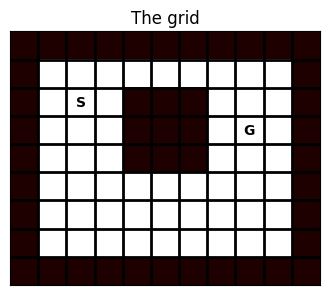

In [401]:
grid = Grid()
grid.plot_grid()
num_actions = 4

## Random agent

In [402]:
# For reference: here is a random agent
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(number_of_actions)
    return next_action


## Agent 1: TD learning
**[5 pts]** Implement an agent that behaves randomly, but that _on-policy_ estimates state values $v(s)$, using one-step TD learning with a step size $\alpha=0.1$.

Also implement `get_values(self)` that returns the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement `get_values` and `step`.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  Hint: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.


In [403]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  def get_values(self):
    return self._values

  def step(self, reward, discount, next_state):
    V_St = self._values[self._state]
    V_S1_t1 = self._values[next_state]
    TD_target = reward + (discount * V_S1_t1)
    TD_error = TD_target - V_St
    a = self._step_size
    self._values[self._state] += a * TD_error

    self._state = next_state

    return np.random.randint(self._number_of_actions)


Run the next cell to run the `RandomTD` agent on a grid world.

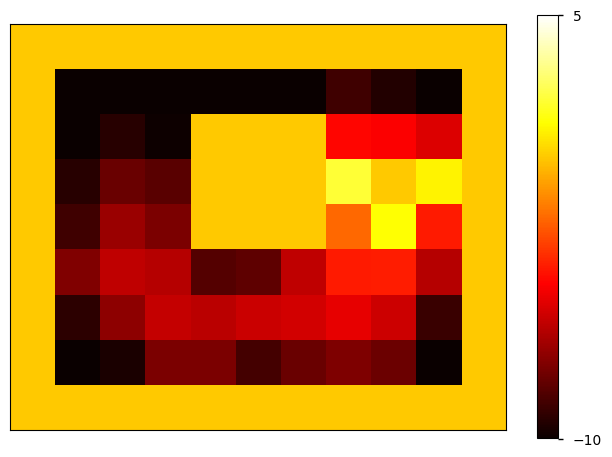

In [404]:
# DO NOT MODIFY THIS CELL
grid = Grid()
init_state = grid.get_obs()
agent = RandomTD(grid._layout.size, num_actions, init_state)
run_experiment(grid, agent, int(1e5))
v = agent.get_values()
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)

If everything worked as expected, the plot above will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange above).

### Policy iteration
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model - so for each state the policy would look at the value of the resulting state for each action, and would then pick the action with the highest state value. You do **not** have to implement this, just answer the following questions.

**[5 pts]** Would the greedy step after one such iteration of policy evaluation and policy improvement be optimal on this problem?  Explain (in one or two sentences) why or why not.

**[5 pts]** If we repeat the process over and over again, and repeatedly evaluate the greedy policy and then perform another improvement step, would then the policy eventually become optimal?  Explain (in one or two sentences) why or why not.

**Question 1:**

No, it's not necessarily to get an optimal policy after one iteration. It is because after each step we find the optimal policy in the current situation, and we only consider the immediate action based on the current value, so we may find the local optimal policy but not the the optimal policy. In addition, we may initialize the value function not good, so we have to do many iterations to corrct it. Moreover, we saw an example in the class about the smal Gridworld that prove my idea.


**Question 2:**

Yes, if we repeat the policy iteration process again and again, we will get the optimal policy. The reason is that after each step the state value get better, so the policy get more accurate and better. Therefore, after enough steps our policy ill convernge to the optimal oplicy. in other words, our policy π converges to π*, something that we saw in the lecture.


## Agent 2: SARSA
**[5 pts]** Implement an $\epsilon$-greedy policy function.

**[10 pts]** Implement a **Sarsa** agent. Now the `__init__` function receives a policy function as input, and you need to maintain a value function for (state, action) pairs, denoted by  **Q**.


In [405]:
class EpsilonGreedy(object):

  def __init__(self, epsilon):
    self._epsilon = epsilon

  def get_action(self, Qvalues, state):
    _num_actions = len(Qvalues[state])
    _eps = self._epsilon / _num_actions
    actions_probality = np.zeros(_num_actions)
    for idx in range(_num_actions):
      actions_probality[idx] = _eps

    _best_action = np.argmax(Qvalues[state])
    actions_probality[_best_action] = (1 - self._epsilon )+_eps

    chosen_action = np.random.choice(_num_actions, p=actions_probality)
    return chosen_action

In [406]:
class Sarsa(object):

  def __init__(self, number_of_states, number_of_actions,
               policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._policy = policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    next_action = self._policy.get_action(self._Qvalues, next_state)
    a = self._step_size
    QS_A = self._Qvalues[self._state, self._action]
    QS2_A2 = self._Qvalues[next_state, next_action]
    res = a * (reward + discount *  QS2_A2 -  QS_A)
    self._Qvalues[self._state, self._action] += res

    self._state = next_state
    self._action = next_action

    return next_action



Run the next cell. This will train your Sarsa agent using an $\epsilon$-greedy policy with $\epsilon=0.1$.

After training a state value is computed using a one-step greedy evaluation:
$V(s) = \max_a Q(s, a)$

The figure on the left shows the value for each state in the grid, and the plot on the right shows the average reward received along the training episodes(always averaged from the first step).

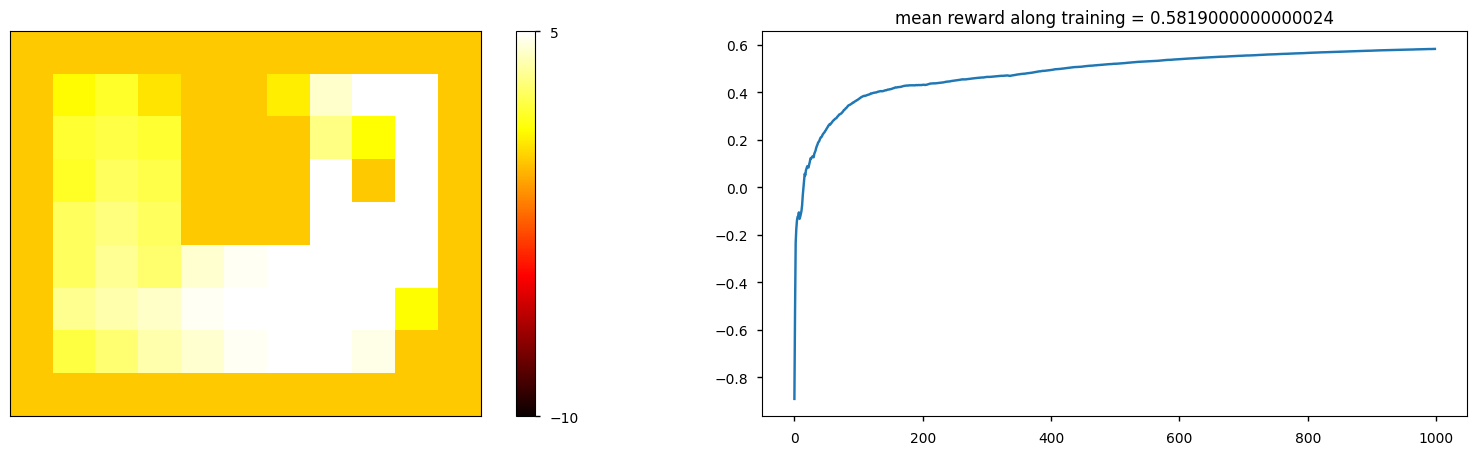

In [407]:
# DO NOT MODIFY THIS CELL
# set-up epsilon greedy policy function with epsilon=0.1
policy = EpsilonGreedy(epsilon=0.1)

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = Sarsa(grid._layout.size, num_actions, policy, init_state)

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))



## Agent 3: Sarsa($\lambda$)
**[10 pts]** Implement a **Sarsa($\lambda$)** agent.
Now you need to maintain a table of eligibility traces, and update the Q-value of all (state, action) pairs in each step.


In [408]:
class SarsaLambda(object):

  def __init__(self, number_of_states, number_of_actions,
               lmbda, policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._Etraces = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._lmbda = lmbda
    self._policy = policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    next_action = self._policy.get_action(self._Qvalues, next_state)

    a = self._step_size
    QS_A = self._Qvalues[self._state, self._action]
    QS2_A2 = self._Qvalues[next_state, next_action]
    TD_error = reward + discount * QS2_A2 - QS_A

    self._Etraces[self._state, self._action] += 1

    self._Qvalues += a * TD_error * self._Etraces
    self._Etraces *= discount * self._lmbda

    self._state = next_state
    self._action = next_action

    return next_action



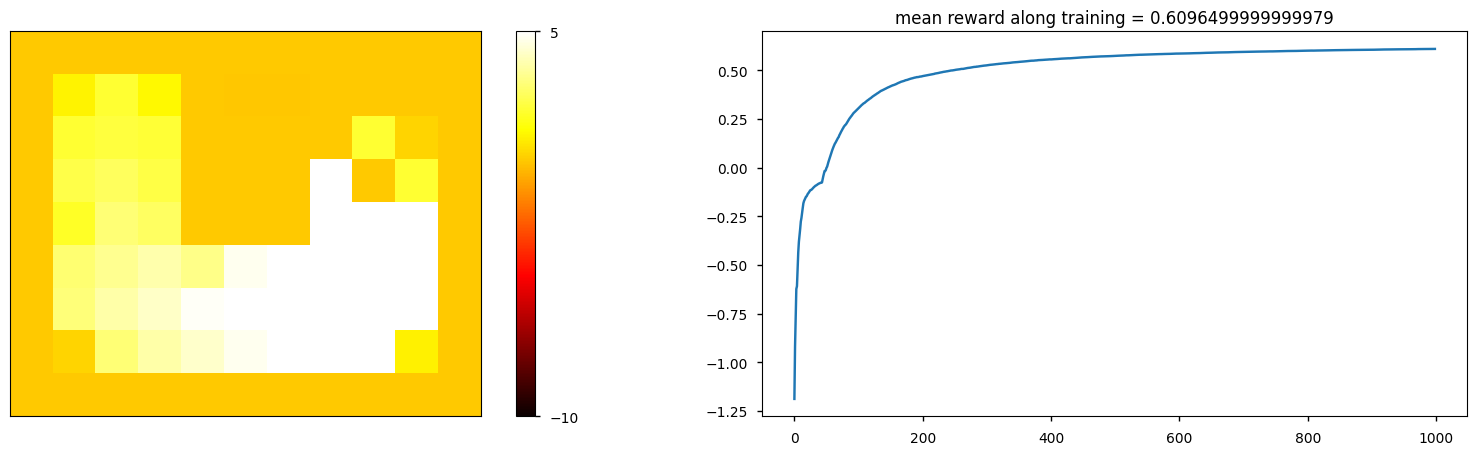

In [409]:
# DO NOT MODIFY THIS CELL
# set-up epsilon greedy policy function with epsilon=0.1
policy = EpsilonGreedy(epsilon=0.1)

lmbda = 0.1

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = SarsaLambda(
    grid._layout.size, num_actions, lmbda, policy, grid.get_obs())

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))



## Agent 4: Q-learning
**[10 pts]** Implement a **Q-learning** agent. The agent recevies a behavior policy at __init__, but always learns the Q values for the greedy policy.


In [410]:
class QLearning(object):

  def __init__(self, number_of_states, number_of_actions,
               policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._policy = policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    next_action = self._policy.get_action(self._Qvalues, next_state)
    a = self._step_size

    QS_A = self._Qvalues[self._state, self._action]
    maxaQ = np.max(self._Qvalues[next_state])
    TD_error = reward + discount * maxaQ - QS_A
    self._Qvalues[self._state, self._action] += a * TD_error

    self._state = next_state
    self._action = next_action

    return next_action



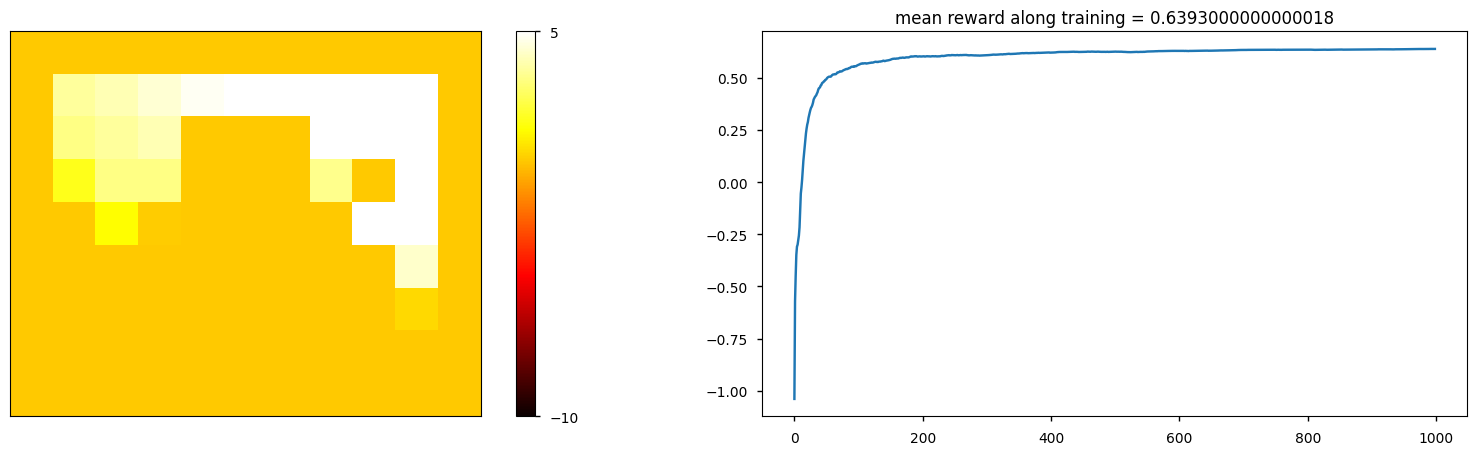

In [411]:
# DO NOT MODIFY THIS CELL
# set-up epsilon greedy policy function with epsilon=0.1
policy = EpsilonGreedy(epsilon=0.1)

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = QLearning(grid._layout.size, num_actions, policy, grid.get_obs())

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))


## Agent 5: General Q-learning
**[15 pts]** Here you will consider a generalization of Q-learning and Sarsa.

Remember from class, that Q learning can be implemented using any two policies:
1. Behavior policy - used to act in the environment
2. Target policy - used as a target for the value updates.

Impement a **General Q-learning** agent, where the `__init__` takes as input a `target_policy` and a  `behavior_policy`.  The agent will act according to the behavior policy, and learn the Q-values of the target policy.
The TD target becomes:
$$r + \gamma \sum_a \mathcal{P}_s^{\texttt{target}}(a) Q(s, a))$$
where $s$ is the new state sent as input to the agent's `step` function.

The standard Q-learning is a special case where the target policy is the greedy policy, and Sarsa is the special case where the target policy is the same as the behavior policy.

**[5 pts]** To implement this, you will first need to add a function to the `EpsilonGreedy` class that returns the probabilities of all actions for a given state.

In [412]:
class EpsilonGreedy(object):

  def __init__(self, epsilon):
    self._epsilon = epsilon

  def get_action_probs(self, Qvalues, state):
    num_actions = len(Qvalues[state])
    _eps = self._epsilon / num_actions
    actions_probality = np.zeros(num_actions)

    for idx in range(num_actions):
      actions_probality[idx] = _eps
      _best_action = np.argmax(Qvalues[state])
      actions_probality[_best_action] = (1 - self._epsilon ) + _eps

    return actions_probality

  def get_action(self, Qvalues, state):
    action_probs = self.get_action_probs(Qvalues, state)
    return np.random.choice(len(Qvalues[state]), p=action_probs)



In [413]:
class GeneralQLearning(object):

  def __init__(self, number_of_states, number_of_actions,
               behavior_policy, target_policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._behavior_policy = behavior_policy
    self._target_policy = target_policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    QA_S= self._Qvalues[self._state, self._action]
    S=self._state
    S_actions_rewards= self._Qvalues[S]
    a=self._step_size

    next_action = self._behavior_policy.get_action(self._Qvalues, next_state)

    target_actions_probality = self._target_policy.get_action_probs(self._Qvalues, next_state)
    expect_next_state_value = 0

    expect_next_state_value = np.sum(target_actions_probality * self._Qvalues[next_state])   ## this is Ptarget(S,a)Q(S,a)

    delta = reward + discount * expect_next_state_value-QA_S
    self._Qvalues[self._state, self._action] +=a * delta
    self._state = next_state
    self._action = next_action

    return next_action



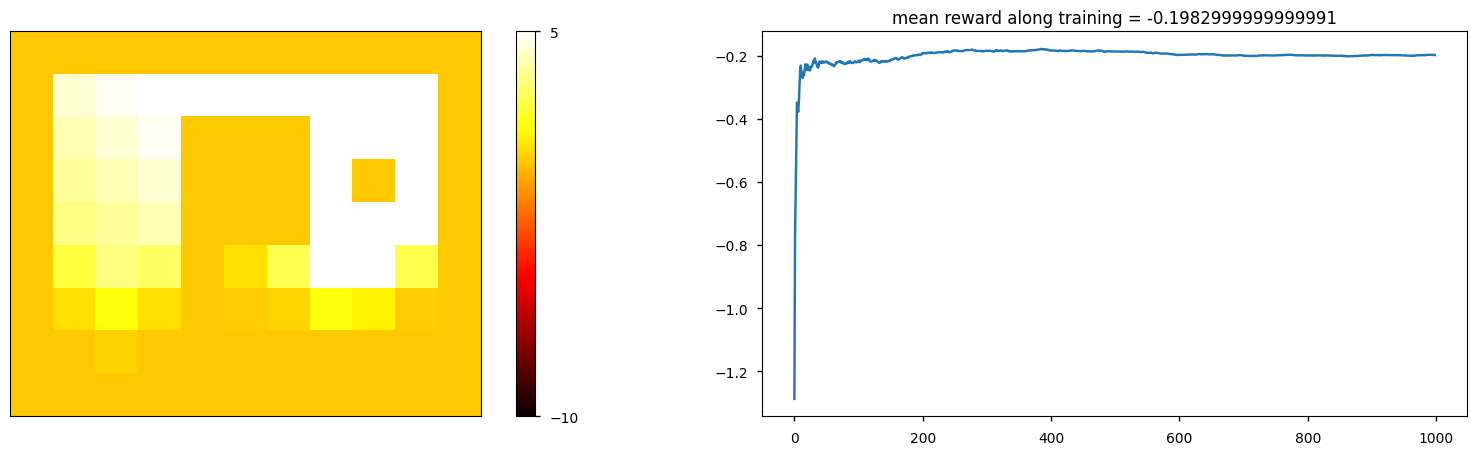

In [414]:
# DO NOT MODIFY THIS CELL
# set-up behavior and target policies
b_policy = EpsilonGreedy(0.5)
t_policy = EpsilonGreedy(0.)

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = GeneralQLearning(grid._layout.size, num_actions,
                         b_policy, t_policy, grid.get_obs())

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))


# Part 2: Analyse Results

## Questions

**[10 pts]** *How* do the policies found by Q-learning and Sarsa differ?  (Explain qualitatively how the behaviour differs in one or two sentences.)

**[10 pts]** *Why* do the policies differ in this way?

**[5 pts]** Run the Sarsa($\lambda$) agent for different values of $\lambda$ (e.g. 0.1 and 0.9), and report the results.

**[5 pts]** Run the general Q-learning agent with different behavior policies and target policies, and report the results.

For the last two questions you can generate plots, reports statistics of rewards and/or values. You can also state any qualitative observation that you make.

**Question 1:**

The policy that is found by Q-learning aims to find the optimal action at each step and it is more deterministic, so we can say that it is more exploitative. While, the policy that is found by Sarsa finds the next step with respect to the other action probabilities, so it aims to make balance between the the actions, and it expolres more actions and states. in addition, as we can see Sarsa method choose a path that goes under the G state and it is a wide path that has a bigger distance, in contrast to the Q-learning method.

**Question 2:**

The policies differ in this way, beacuse of the way of updating the Q-values: The Q-learning method upate its Q-values according to the estimated Q-value of the action that is chhisen greedily. While, the Sarsa methos update its Q-values according to the estimated Q-value of the next state that is choosen according to the EpsilonGreedy method. As we see, the Q-learning method's updates are more deterministic, and Sarsa method's updates are more balanced because it uses EpsilonGreedy method, which act with respect to the probabilities of the different action.

The reason of the differnce between the 2 pathes of the 2 methods, is because when we are in the beginning of the Sarsa method, we may hit the wall so we get a bad reward, therfore in the next action we prefer not to do the same action. While, in the Q-learning method when we hit the wall, we get a bad rewad, but this bad reward will not affect our choice of the next action, because we have 2 different policies: the behaviour policy and the target policy.  

**Question 3:**

We Run Sarsa(λ) with 2 values of λ: 0.1 and 0.9. And the results that we got: When the λ=0.1 we saw that the picture of the grid didn't get to the cell above the end cell G (the cell with the reward), it means it discover the path under the cell G, and after it gets to cell G, it doesn't continue to explore above it, only single cells. While when λ=0.1, the picture of the grid when it get to the cell G, it continued to discover the line above it. It is expected because when λ is smaller it converges to 0 more quickly than big λ, so it explore less cells.

In addition, we saw that the mean reward is a little bigger when λ is smaller. This is also expected because small λ converges to 0 more quickly, so it only give importance to the recent values and. In contrast, to λ=0.9 that explore more values and states, but it is not always helpful, because it may explore values that will not help, so the mean reward may increase.
This is the output for λ=0.1:
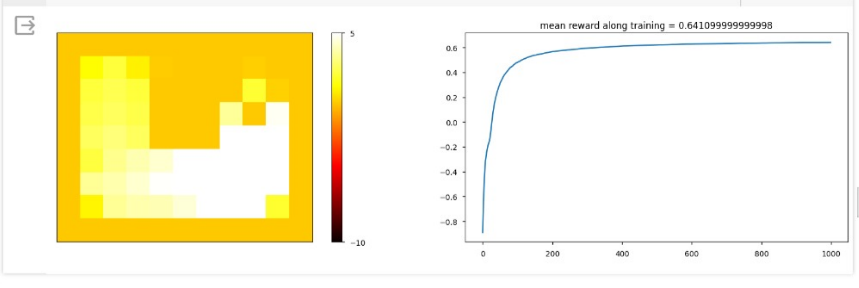
And the output for λ=0.9:
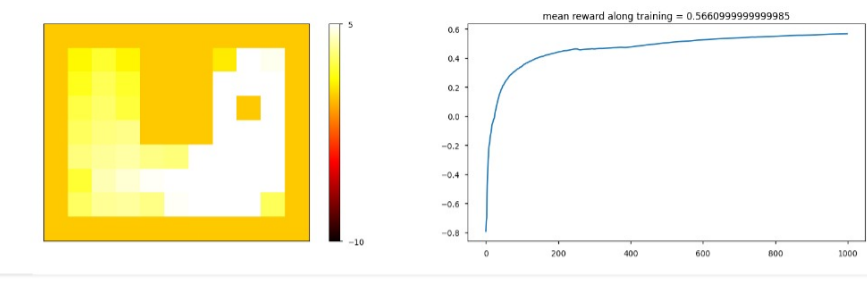

We also have checked for λ=0.8 and λ=0.2, and get the similar result:

And the output for λ=0.8:
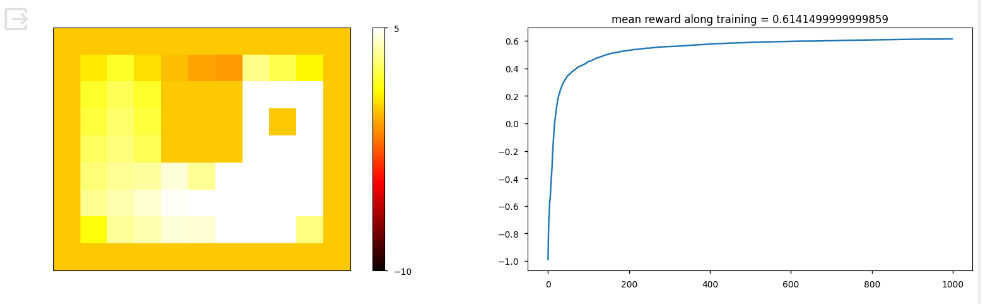
And the output for λ=0.2:
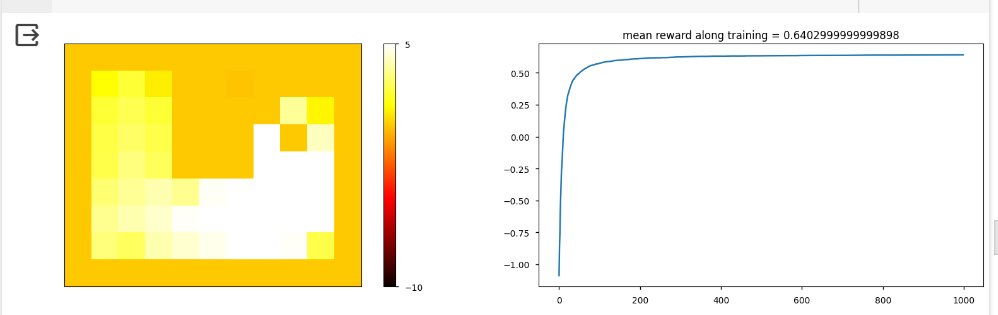

**Question 4:**

We have ran the GeneralQLearning method with differnt values of ϵ for the behaviour and target policies, and we get some results that we will shoe the output of some of them:

* When ϵ=0.9 for behaviour and target policy:
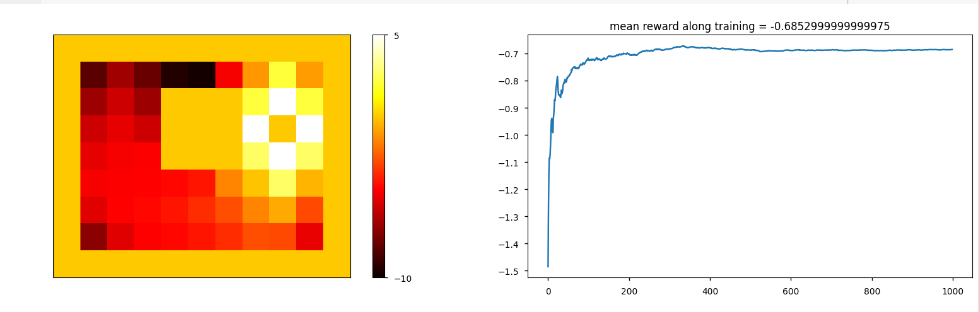
We can see that it is not good at all, because we don't give importance for the action with the highest value function, and it is similar to behaving randomaly, so it explores many states.

* When ϵ=0 for behaviour policy, and ϵ=0.9 for target policy:
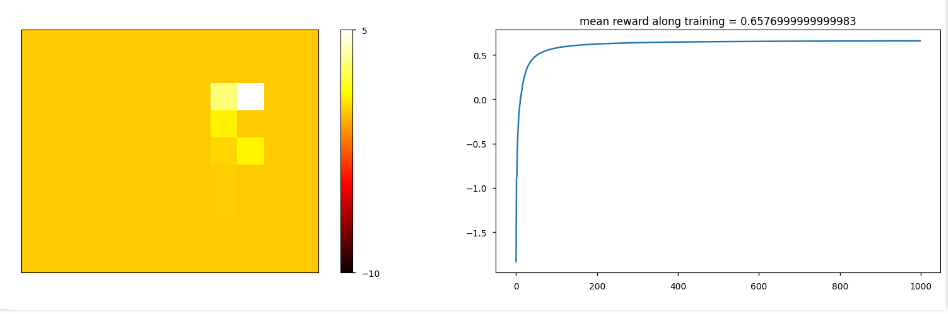
As we can see, the algorithm didn't manage to visit all the states in the Grid, because its behaviour was approxiametly greedy.

* When ϵ=0 for behaviour, and ϵ=0.1 for target policy:
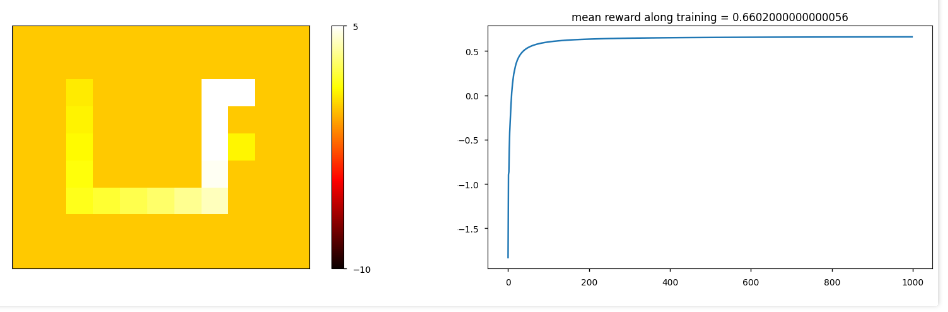
As we can see here, it didn't explore all the states, because it acts greedy. But, it is better than ϵ=0.9 for the target, because it gives more importance to the states with high value (Q-value).

* When ϵ=0.1 for behaviour, and ϵ=0 for tareget policy:
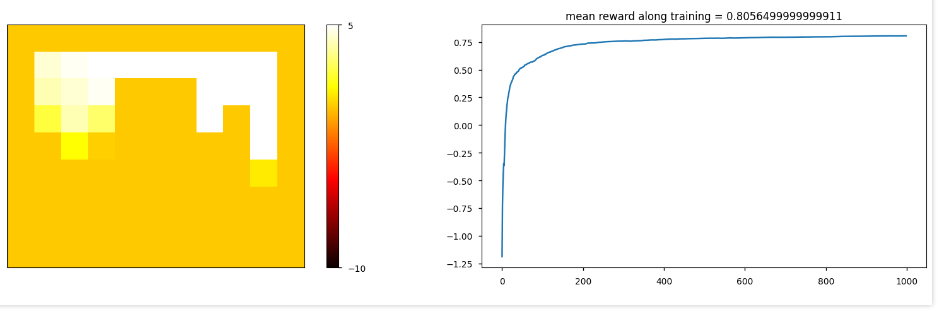
As we can see, it is like Q-learning. It is true because: ϵ for the target policy is 0, it means the target policy is greedy, and ϵ=0.1 (or it can be other value) so that behaviour policy is EpsilonGreedy.

* When ϵ=0.9 for behaviour, and ϵ=0 for target policy:
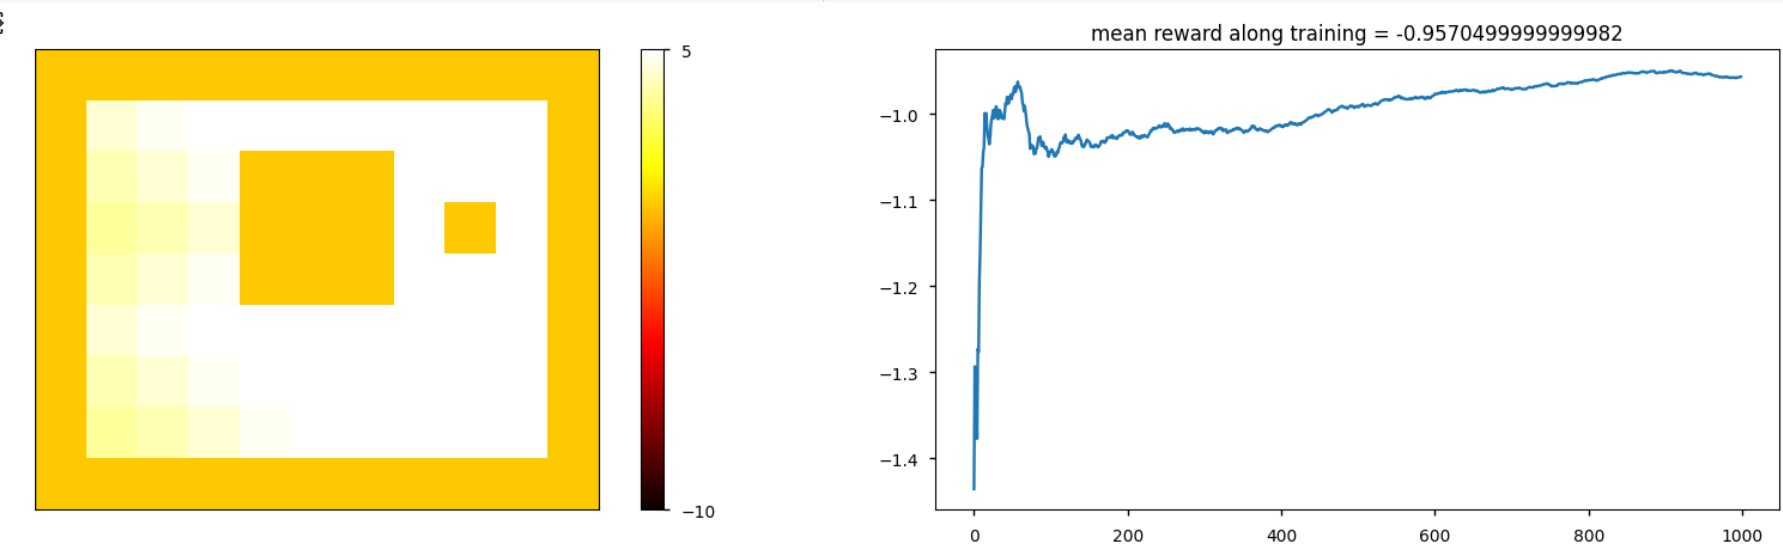
As we can see, it is Q-learning, but there is diffrernces from thr regualr Q-learning ith ϵ=0.1. This is because, when ϵ is big, we don't give too much importance to the states with high value, and it is similar to the random policy, therfore we will expolre more states.

* When ϵ=0.1 for both behaviour and target policy:
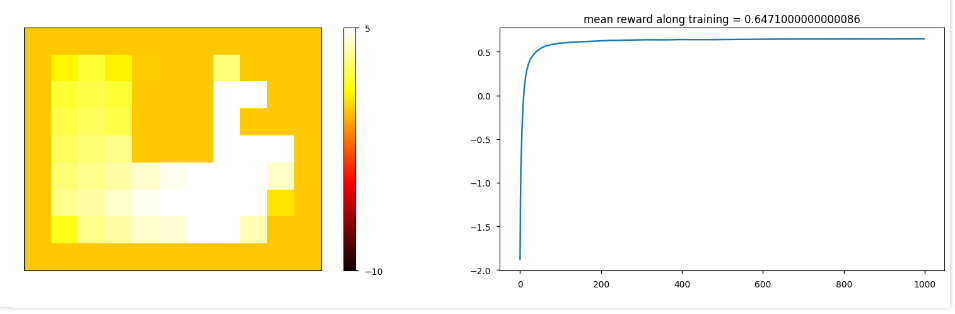
As we can, and as we know when the epsilon is equal foe the 2 policies, it behaves like Sarsa, because it means that the two behaviours are the same,
(the same EpsilonGreedy). In addition, it is like Sarsa in the way that it goes down and find the path by going down and under the G state, in contrast to Q-learning.

* When ϵ=0.1 for behavior and ϵ=0.9 for target policy:
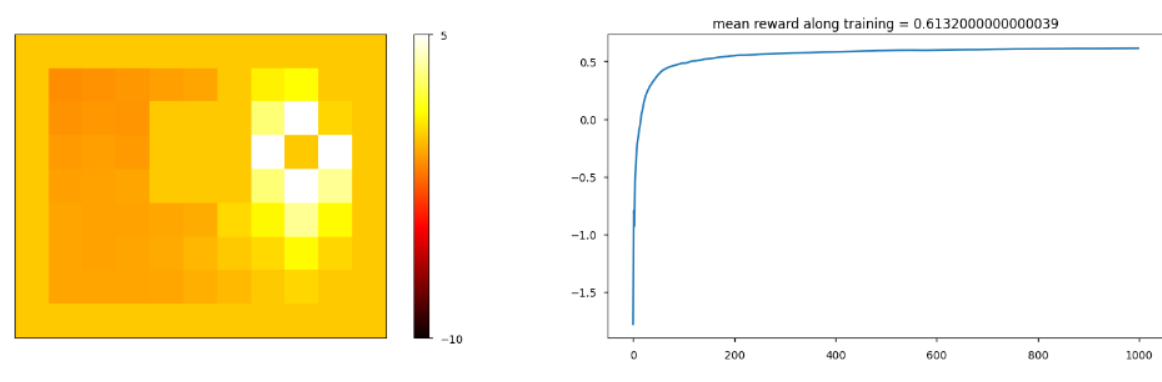
As we can see, it is not better, because the target policy is more random, and the target policy is far away from Greedy policy.

* When ϵ=0.9 for behaviour and ϵ=0.1 for target policy:
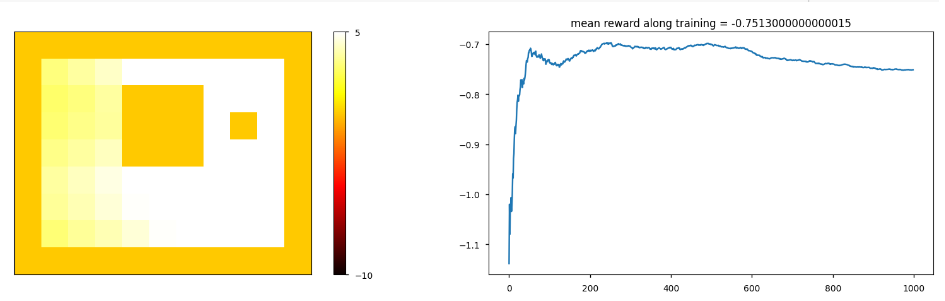
As we can see, it is more random than ϵ=0.1 for the 2 policies, this is because the randomness when ϵ is big, in the behaviour policy.
